<a href="https://colab.research.google.com/github/x23425237/DeepLearning_GenAI/blob/main/JPM_EDA_MA_adfuller_Bharathi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**JP-Morgan - Daily Stock price Analysis and LSTM **

In [ ]:
import numpy as np
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,RepeatVector,TimeDistributed
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
import tensorflow as tf
from tensorflow.keras import layers

set_seed(455)
np.random.seed(455)

In [ ]:
# get data from api  Alpha Vantage Stock API
# G2DBRN7KCM4QHZWY
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=JPM&interval=5min&outputsize=full&apikey=G2DBRN7KCM4QHZWY'
r = requests.get(url)
data = r.json()

print(data)




{'Meta Data': {'1. Information': 'Intraday (5min) open, high, low, close prices and volume', '2. Symbol': 'JPM', '3. Last Refreshed': '2025-04-04 19:55:00', '4. Interval': '5min', '5. Output Size': 'Full size', '6. Time Zone': 'US/Eastern'}, 'Time Series (5min)': {'2025-04-04 19:55:00': {'1. open': '210.0000', '2. high': '213.2300', '3. low': '209.8600', '4. close': '210.4000', '5. volume': '1184'}, '2025-04-04 19:50:00': {'1. open': '209.8000', '2. high': '210.2000', '3. low': '209.8000', '4. close': '210.2000', '5. volume': '218'}, '2025-04-04 19:45:00': {'1. open': '210.1900', '2. high': '210.2000', '3. low': '209.8000', '4. close': '209.8000', '5. volume': '681'}, '2025-04-04 19:40:00': {'1. open': '210.0000', '2. high': '210.2000', '3. low': '209.4500', '4. close': '210.1900', '5. volume': '362'}, '2025-04-04 19:35:00': {'1. open': '209.6500', '2. high': '210.2800', '3. low': '209.6000', '4. close': '210.0000', '5. volume': '8118'}, '2025-04-04 19:30:00': {'1. open': '210.0000', '

In [ ]:
time_series = data.get('Time Series (5min)', {})
df=pd.DataFrame.from_dict(time_series,orient='index')

df['1. open'] = df['1. open'].astype(float)
df['2. high'] = df['2. high'].astype(float)
df['3. low'] = df['3. low'].astype(float)
df['4. close'] = df['4. close'].astype(float)
df['5. volume'] = df['5. volume'].astype(int)


In [ ]:
df.head()

,1. open,2. high,3. low,4. close,5. volume
2025-04-04 19:55:00,210.00,213.23,209.86,210.40,1184
2025-04-04 19:50:00,209.80,210.20,209.80,210.20,218
2025-04-04 19:45:00,210.19,210.20,209.80,209.80,681
2025-04-04 19:40:00,210.00,210.20,209.45,210.19,362
2025-04-04 19:35:00,209.65,210.28,209.60,210.00,8118


In [ ]:
# rename the columns
dict = {'1. open': 'Open',
        '2. high': 'High',
        '3. low': 'Low',
        '4. close': 'Close',
        '5. volume': 'Volume'
        }
df.rename(columns=dict,
          inplace=True)

display(df)


,Open,High,Low,Close,Volume
2025-04-04 19:55:00,210.0000,213.2300,209.8600,210.4000,1184
2025-04-04 19:50:00,209.8000,210.2000,209.8000,210.2000,218
2025-04-04 19:45:00,210.1900,210.2000,209.8000,209.8000,681
2025-04-04 19:40:00,210.0000,210.2000,209.4500,210.1900,362
2025-04-04 19:35:00,209.6500,210.2800,209.6000,210.0000,8118
...,...,...,...,...,...
2025-03-06 04:20:00,247.4724,247.4724,247.3532,247.3631,178
2025-03-06 04:15:00,247.6413,247.6611,247.3631,247.3631,288
2025-03-06 04:10:00,247.8300,247.8300,247.6512,247.8300,137
2025-03-06 04:05:00,247.6512,248.1578,247.6512,248.1578,261


In [ ]:
df.describe()


,Open,High,Low,Close,Volume
count,4112.000000,4112.000000,4112.000000,4112.000000,4.112000e+03
mean,236.817716,237.231227,236.457722,236.781519,1.107192e+05
std,8.925536,8.910279,8.978746,8.908330,4.436297e+05
min,209.210000,209.890000,202.533300,209.000000,1.000000e+00
25%,230.572325,230.863000,230.274400,230.535100,1.200000e+02
50%,237.846500,238.293500,237.610650,237.794300,2.563500e+03
75%,243.962025,244.345675,243.548500,243.898375,8.732850e+04
max,273.568600,274.760700,252.558300,260.918600,1.253169e+07


In [ ]:
# show missing vlues , unique values,datatype and count
def show_missing(df):

    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    pc_missing = []

    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pc_missing.append(round((df[item].isna().sum() / len(df[item])) * 100, 2))

    output = pd.DataFrame({
        'variable': variables,
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing': missing,
        'pc_missing': pc_missing
    })

    return output




In [ ]:
show_missing(df)


,variable,dtype,count,unique,missing,pc_missing
0,Open,float64,4112,2386,0,0.0
1,High,float64,4112,2301,0,0.0
2,Low,float64,4112,2291,0,0.0
3,Close,float64,4112,2433,0,0.0
4,Volume,int64,4112,2828,0,0.0


In [ ]:
reset_index=df.reset_index()
reset_index.rename(columns={'index': 'DateTime'}, inplace=True)


reset_index.head()

,DateTime,Open,High,Low,Close,Volume
0,2025-04-04 19:55:00,210.00,213.23,209.86,210.40,1184
1,2025-04-04 19:50:00,209.80,210.20,209.80,210.20,218
2,2025-04-04 19:45:00,210.19,210.20,209.80,209.80,681
3,2025-04-04 19:40:00,210.00,210.20,209.45,210.19,362
4,2025-04-04 19:35:00,209.65,210.28,209.60,210.00,8118


In [ ]:
# change dateime object to datetime
reset_index['DateTime'] = pd.to_datetime(reset_index['DateTime'])

In [ ]:
# add a date column
reset_index.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  4112 non-null   datetime64[ns]
 1   Open      4112 non-null   float64       
 2   High      4112 non-null   float64       
 3   Low       4112 non-null   float64       
 4   Close     4112 non-null   float64       
 5   Volume    4112 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 192.9 KB


In [ ]:
reset_index.head()

,DateTime,Open,High,Low,Close,Volume
0,2025-04-04 19:55:00,210.00,213.23,209.86,210.40,1184
1,2025-04-04 19:50:00,209.80,210.20,209.80,210.20,218
2,2025-04-04 19:45:00,210.19,210.20,209.80,209.80,681
3,2025-04-04 19:40:00,210.00,210.20,209.45,210.19,362
4,2025-04-04 19:35:00,209.65,210.28,209.60,210.00,8118


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

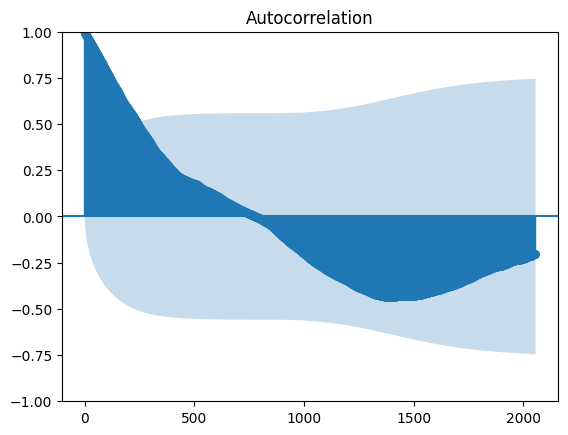

In [ ]:
# ACF plot
plot_acf(reset_index['Close'], lags=len(reset_index)//2)
plt.show()

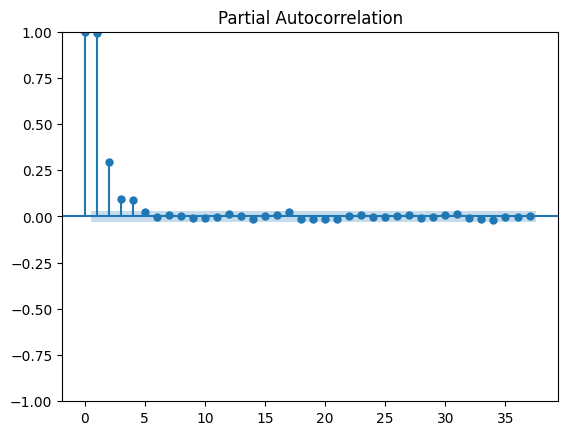

In [ ]:
# PACF plot shows significant lags at lag 1,2,3 and 4
plot_pacf(reset_index['Close'])
plt.show()

In [ ]:
#perform augmented Dickey-Fuller test
# p value not less than 0.05 - fail to reject null hyphotheisis. This means the time series is non-stationary
adfuller(reset_index['Close'])

(np.float64(-2.805996600561521),
 np.float64(0.05742228866628529),
 6,
 4105,
 {'1%': np.float64(-3.431944005815688),
  '5%': np.float64(-2.8622443444095516),
  '10%': np.float64(-2.567144929180866)},
 np.float64(9421.511024165306))

In [ ]:
reset_index['Date'] = reset_index['DateTime'].dt.date

# Extract the time part
reset_index['Time'] = reset_index['DateTime'].dt.time


In [ ]:
reset_index.head()

,DateTime,Open,High,Low,Close,Volume,Date,Time
0,2025-03-26 19:55:00,249.11,249.5300,249.00,249.02,162,2025-03-26,19:55:00
1,2025-03-26 19:50:00,249.10,249.9988,248.60,249.11,503,2025-03-26,19:50:00
2,2025-03-26 19:45:00,249.10,249.1000,249.09,249.10,223,2025-03-26,19:45:00
3,2025-03-26 19:40:00,248.55,249.1000,248.55,249.10,115,2025-03-26,19:40:00
4,2025-03-26 19:35:00,248.51,249.1000,248.51,248.90,42,2025-03-26,19:35:00


In [ ]:
reset_index.set_index('DateTime', inplace=True)



In [ ]:
reset_index.head()

,Open,High,Low,Close,Volume,Date,Time
DateTime,,,,,,,
2025-03-26 19:55:00,249.11,249.5300,249.00,249.02,162,2025-03-26,19:55:00
2025-03-26 19:50:00,249.10,249.9988,248.60,249.11,503,2025-03-26,19:50:00
2025-03-26 19:45:00,249.10,249.1000,249.09,249.10,223,2025-03-26,19:45:00
2025-03-26 19:40:00,248.55,249.1000,248.55,249.10,115,2025-03-26,19:40:00
2025-03-26 19:35:00,248.51,249.1000,248.51,248.90,42,2025-03-26,19:35:00


In [ ]:
show_missing(reset_index)

,variable,dtype,count,unique,missing,pc_missing
0,Open,float64,4120,2500,0,0.0
1,High,float64,4120,2363,0,0.0
2,Low,float64,4120,2417,0,0.0
3,Close,float64,4120,2563,0,0.0
4,Volume,int64,4120,2770,0,0.0
5,Date,object,4120,22,0,0.0
6,Time,object,4120,192,0,0.0


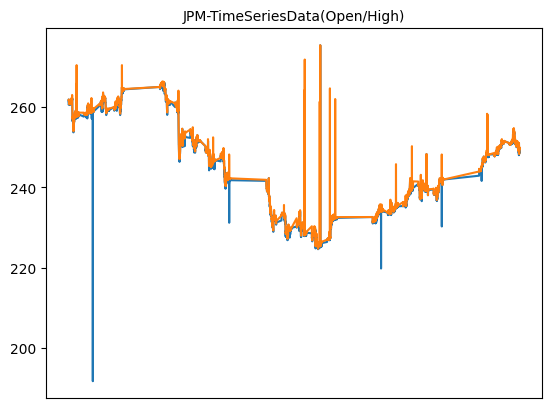

In [ ]:
# https://www.datacamp.com/tutorial/matplotlib-tutorial-python
# plot all timeseries
plt.plot( reset_index['Open'])
plt.plot( reset_index['High'])
plt.title('JPM-TimeSeriesData(Open/High)', fontsize=10)
plt.xticks([])
plt.show()


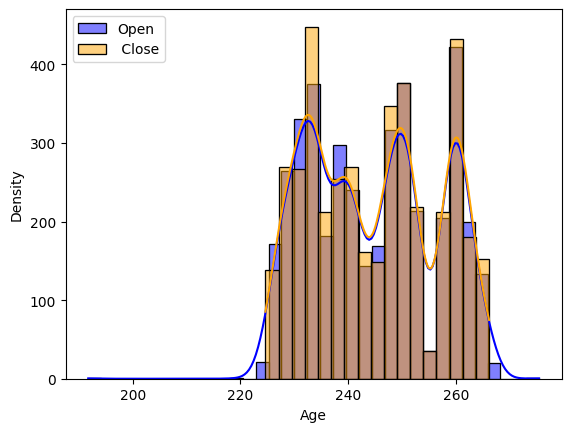

In [ ]:
# Plotting overlapping histograms
#https://www.geeksforgeeks.org/plot-multiple-histograms-on-same-plot-with-seaborn/
sns.histplot(data=reset_index['Open'], color='blue', alpha=0.5, kde=True, label='Open')
sns.histplot(data=reset_index['Close'], color='orange', alpha=0.5, kde=True, label=' Close')

# Adding labels and legend
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()

plt.show()

In [ ]:
# create data subsets : show only prices from yesterday.
df1=iltered_df = reset_index[reset_index['Date'] >pd.to_datetime('2025-03-25').date()]

df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2025-03-26 19:55:00 to 2025-03-26 04:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    184 non-null    float64
 1   High    184 non-null    float64
 2   Low     184 non-null    float64
 3   Close   184 non-null    float64
 4   Volume  184 non-null    int64  
 5   Date    184 non-null    object 
 6   Time    184 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 11.5+ KB


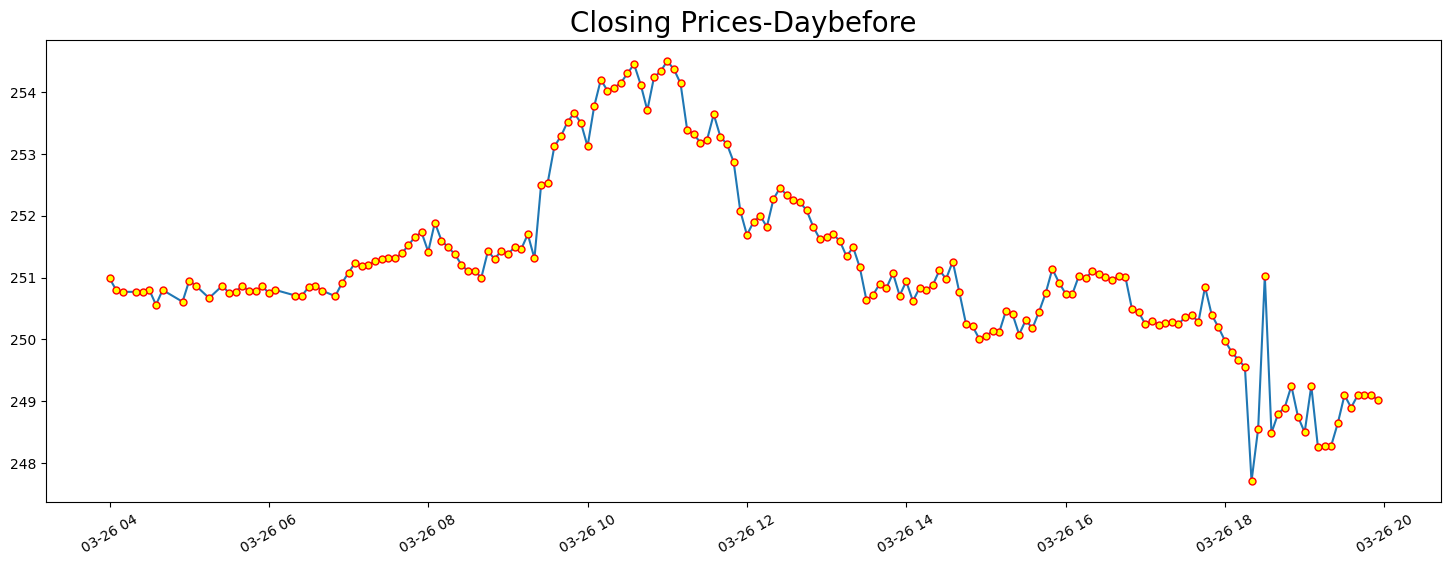

In [ ]:
# https://www.datacamp.com/tutorial/matplotlib-time-series-line-plot
# plot closing prices
plt.figure(figsize=(18, 6))
plt.plot(df1.index, df1['Close'],marker='o', markerfacecolor='yellow', markeredgecolor='red', markersize=5)
plt.xticks(rotation=30, fontsize=10)
plt.title('Closing Prices-Daybefore', fontsize=20)
plt.show()




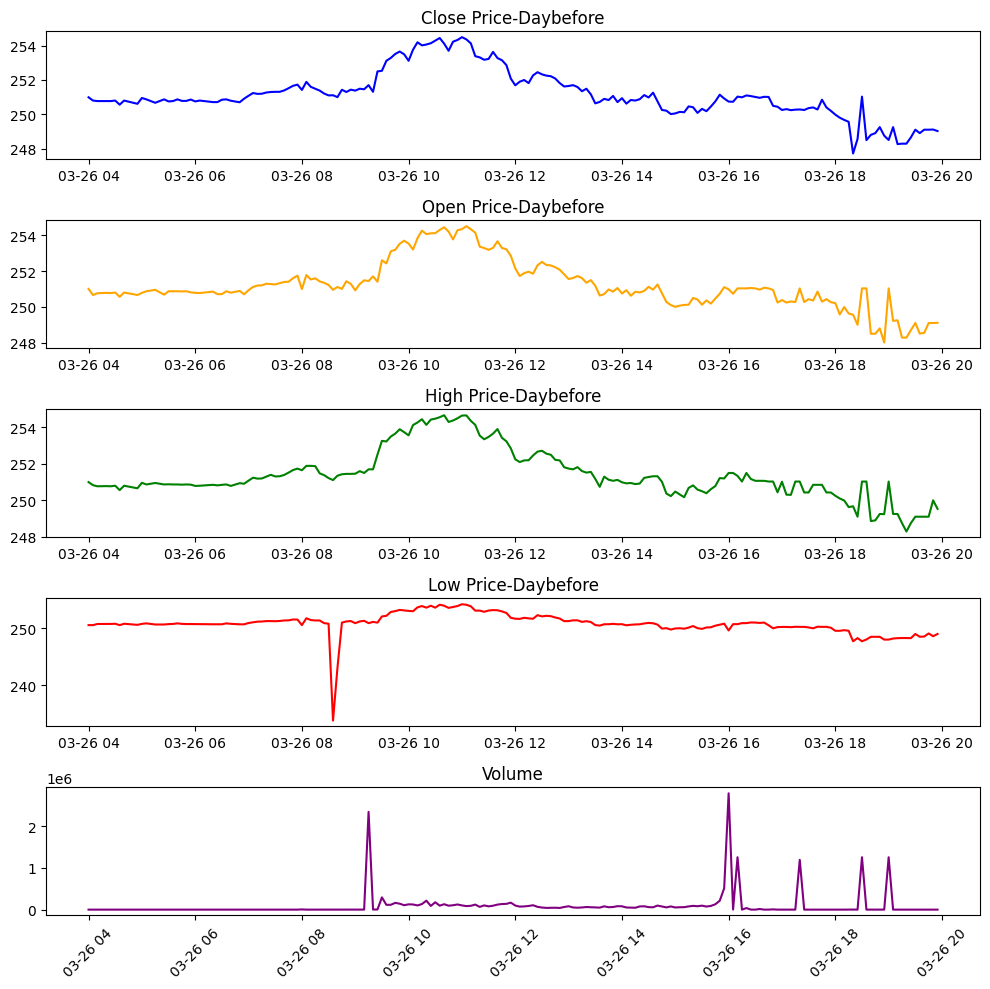

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10))
axs[0].plot(df1.index, df1['Close'], color='blue')
axs[0].set_title('Close Price-Daybefore')

axs[1].plot(df1.index, df1['Open'], color='orange')
axs[1].set_title('Open Price-Daybefore')


axs[2].plot(df1.index, df1['High'], color='green')
axs[2].set_title('High Price-Daybefore')

axs[3].plot(df1.index, df1['Low'], color='red')
axs[3].set_title('Low Price-Daybefore')

axs[4].plot(df1.index, df1['Volume'], color='purple')
axs[4].tick_params(axis='x', rotation=45)
axs[4].set_title('Volume')

plt.tight_layout()
plt.show()

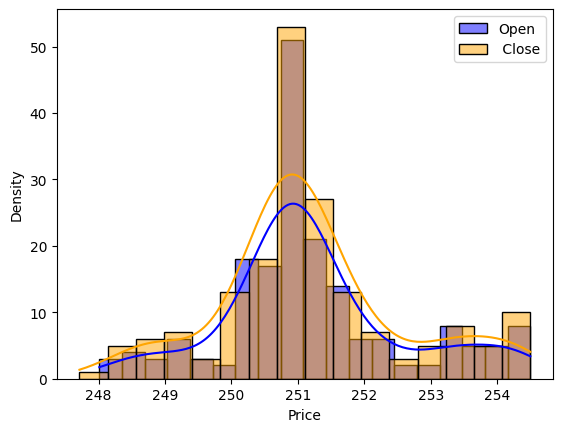

In [ ]:
sns.histplot(data=df1['Open'], color='blue', alpha=0.5, kde=True, label='Open')
sns.histplot(data=df1['Close'], color='orange', alpha=0.5, kde=True, label=' Close')

# Adding labels and legend
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

plt.show()

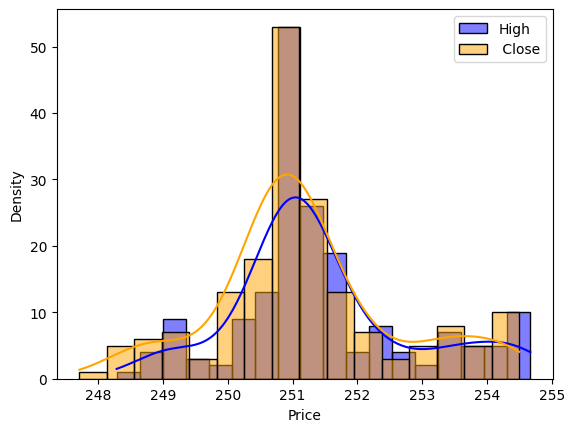

In [ ]:
sns.histplot(data=df1['High'], color='blue', alpha=0.5, kde=True, label='High')
sns.histplot(data=df1['Close'], color='orange', alpha=0.5, kde=True, label=' Close')

# Adding labels and legend
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

plt.show()

In [ ]:
# Implementing moving average
# Calculate 12-month simple moving average
df2=reset_index[['Close']]

df2.head()



,Close
DateTime,
2025-03-26 19:55:00,249.02
2025-03-26 19:50:00,249.11
2025-03-26 19:45:00,249.10
2025-03-26 19:40:00,249.10
2025-03-26 19:35:00,248.90


In [ ]:
df3=reset_index[['Close', 'Open', 'High']]

In [ ]:
sma = df2.rolling(window = 12).mean()

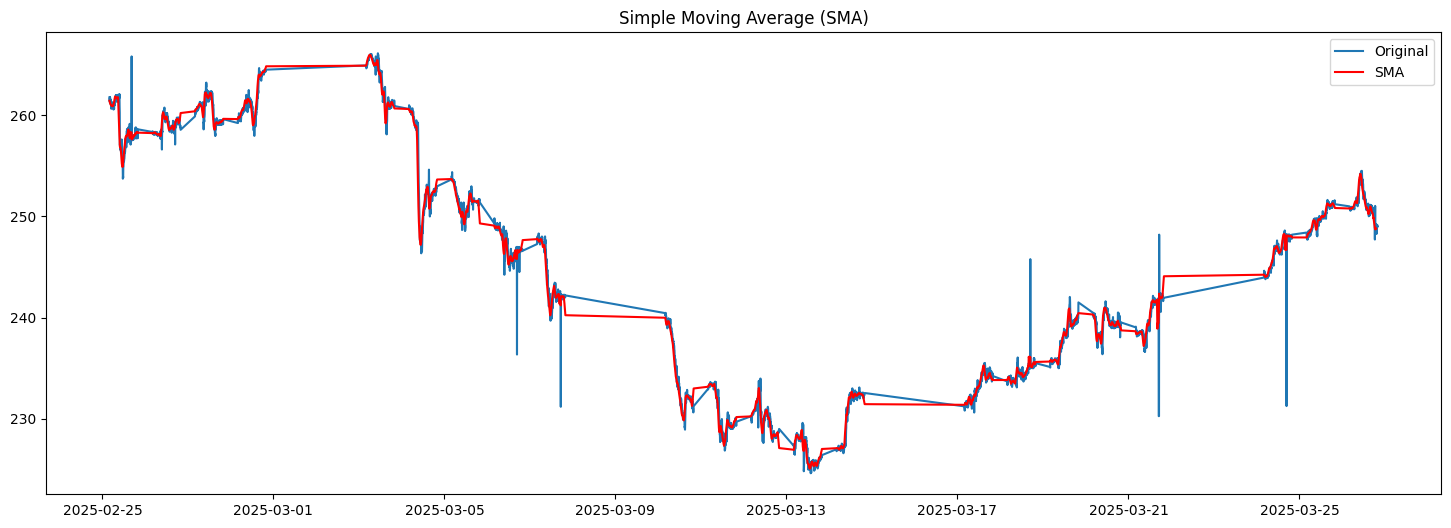

In [ ]:
plt.figure(figsize = (18, 6))
plt.plot(df2, label = 'Original')
plt.plot(sma, label = 'SMA', color = 'red')
plt.title('Simple Moving Average (SMA)')
plt.legend()
plt.show()

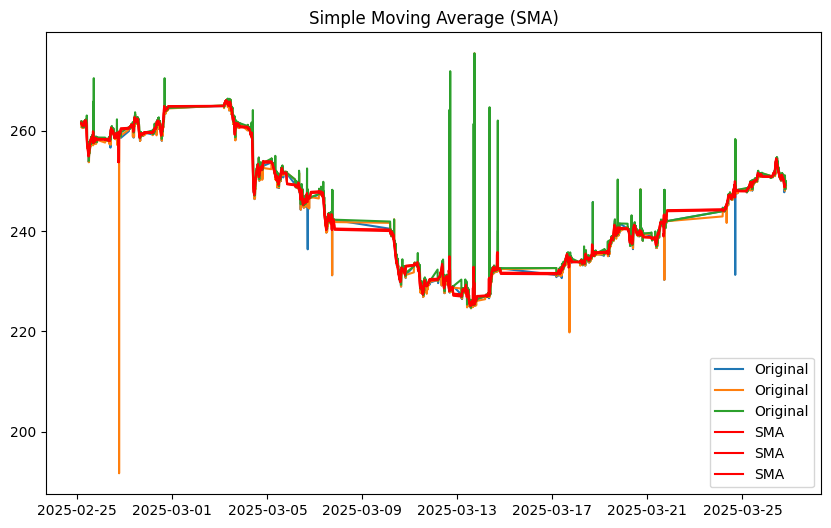

In [ ]:
sma2 = df3.rolling(window = 12).mean()

plt.figure(figsize = (10, 6))
plt.plot(df3, label = 'Original')
plt.plot(sma2, label = 'SMA', color = 'red')
plt.title('Simple Moving Average (SMA)')
plt.legend()
plt.show()

In [ ]:
sma_dropna=sma['Close'].dropna()
sma_dropna # 4109 rows

,Close
DateTime,
2025-03-26 19:00:00,248.796617
2025-03-26 18:55:00,248.774117
2025-03-26 18:50:00,248.785783
2025-03-26 18:45:00,248.769117
2025-03-26 18:40:00,248.744117
...,...
2025-02-25 04:20:00,261.151667
2025-02-25 04:15:00,261.232500
2025-02-25 04:10:00,261.318333


In [ ]:
df2_skip11= df2['Close'].iloc[11:]

In [ ]:
# ensure both are same length
len(sma_dropna)#4109
len(df2) # 4120
len(df2_skip11)#4109

4109

In [ ]:
mse = mean_squared_error(df2_skip11, sma_dropna)
print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 0.6667397092336097
